In [1]:
import os
import pandas as pd
import numpy as np
import pathlib
import tensorflow as tf
import time
import skimage as ski
import matplotlib.pyplot as plt
import random
from PIL import Image
from sklearn.metrics import roc_curve, auc, precision_recall_curve

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.optimizers.legacy import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
tf.__version__

'2.15.0'

In [4]:
!wget 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'

--2024-04-22 20:19:19--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 2.23.221.208, 2a02:26f0:1180:382::317f, 2a02:26f0:1180:39e::317f
Connecting to download.microsoft.com (download.microsoft.com)|2.23.221.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   137MB/s    in 6.4s    

2024-04-22 20:19:26 (124 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [ ]:
!unzip /content/kagglecatsanddogs_5340.zip

In [6]:
start = time.time()
wdir = 'PetImages/'
data = []
bad_imgs = os.path.join('bad_imgs/')
os.makedirs(bad_imgs, exist_ok=True)
for dirname, _, filenames in os.walk(wdir):
    for filename in filenames:
        dir = os.path.basename(dirname)  # Extract breed from the directory
        filetype = filename[-3:]
        try:
            image = ski.io.imread(f'{wdir}{dir}/{filename}')
        except:
            try:
                print(f'Read error for "{wdir}{dir}/{filename}", attempting to move')
                os.rename(f'{wdir}{dir}/{filename}', bad_imgs)
            except:
                os.remove(f'{wdir}{dir}/{filename}')
                print(f'Could not move {wdir}{dir}/{filename}, removing file')
        else:
            data.append({'filename': f'{wdir}{dir}/{filename}', 'class': dir, 'filetype': filetype})
train_df = pd.DataFrame(data).sample(frac=1) #shuffling the data
cwd = os.getcwd()
end = time.time()
duration = end - start
print('Reading images took ', duration, ' seconds')

Read error for "PetImages/Cat/666.jpg", attempting to move
Could not move PetImages/Cat/666.jpg, removing file
Read error for "PetImages/Cat/10404.jpg", attempting to move
Could not move PetImages/Cat/10404.jpg, removing file
Read error for "PetImages/Cat/Thumbs.db", attempting to move
Could not move PetImages/Cat/Thumbs.db, removing file


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Read error for "PetImages/Dog/Thumbs.db", attempting to move
Could not move PetImages/Dog/Thumbs.db, removing file
Read error for "PetImages/Dog/11702.jpg", attempting to move
Could not move PetImages/Dog/11702.jpg, removing file
Reading images took  42.72354745864868  seconds


In [3]:
train_datagen = ImageDataGenerator(
    rotation_range=5,
    rescale=1./255,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

img_height, img_width = 200, 224
batch_size = 64

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle = True)

val_generator = train_datagen.flow_from_dataframe(
    train_df,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("Class Indices:", train_generator.class_indices)

In [9]:
np.array(val_generator.classes).sum() #how many dog images are in the validation set (out of 4996)

2486

## Looking at a few raw images

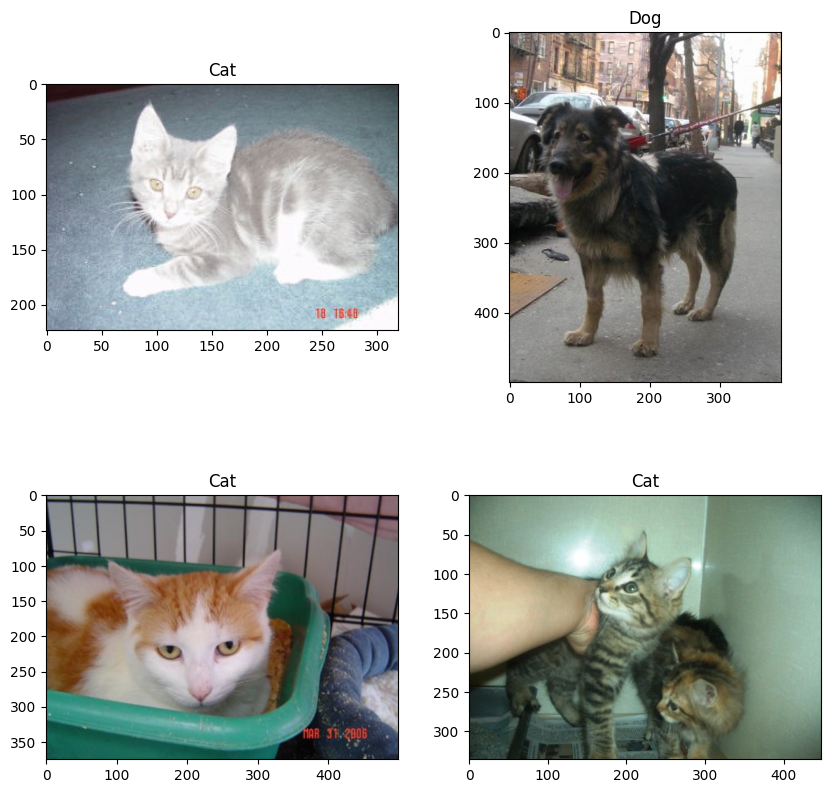

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs = axs.ravel()
for i in range(0,4):
    idx = random.choice(train_df.index)
    axs[i].imshow(Image.open(train_df['filename'][idx]))
    axs[i].set_title(train_df['class'][idx])

## Check out some augmented ones

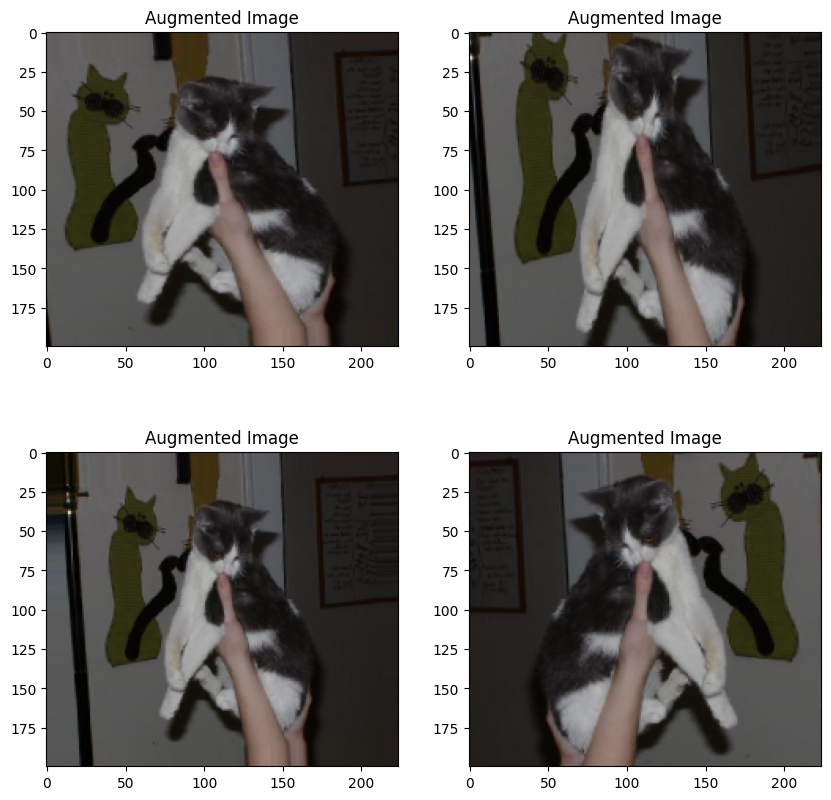

In [11]:
# Generate augmented images
augmented_images = [train_generator[0][0][0] for _ in range(4)]

# Plot augmented images
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, image in enumerate(augmented_images):
    axs[i // 2, i % 2].imshow(image)
    axs[i // 2, i % 2].set_title('Augmented Image')
plt.show()


In [5]:
def F1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [7]:
img_shape = (200,224,3)

class_count = 2 #2

inputs = tf.keras.layers.Input(shape=img_shape)
base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_tensor=inputs, pooling='max')

# Additional layers
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(base_model.output)
x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.4, seed=123)(x)
output = Dense(class_count, activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=output)

lr = 0.001
model.compile(optimizer=Adamax(learning_rate=lr),
              loss='categorical_crossentropy',
              metrics=['accuracy', F1_score])

print(f'Created EfficientNetV2B0 model with initial learning rate set to {lr}')

Created EfficientNetV2B0 model with initial learning rate set to 0.001


In [14]:
checkpoint_filepath = '/content/drive/MyDrive/HW4/checkpoint.model.weights.h5'
csv_log_filepath = '/content/drive/MyDrive/HW4/training.log'

csv_logger = CSVLogger(csv_log_filepath)

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    mode='max',
    save_weights_only = True,
    save_best_only=True)

steps_per_epoch = len(train_generator.filenames) // train_generator.batch_size
validation_steps = len(val_generator.filenames) // val_generator.batch_size

In [25]:
model.load_weights('checkpoint_9873.model.weights.h5')
model = load_model('checkpoint_9858.model.weights (1).h5', custom_objects={'F1_score': F1_score})

In [23]:
history = model.fit(train_generator, epochs=24, steps_per_epoch=steps_per_epoch,
                    validation_data=val_generator, validation_steps=validation_steps,
                    callbacks=[model_checkpoint_callback, csv_logger])

Epoch 1/24
244/312 [======================>.......] - ETA: 1:02 - loss: 0.7047 - accuracy: 0.9764 - F1_score: 0.9764

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


312/312 [==============================] - 398s 1s/step - loss: 0.6378 - accuracy: 0.9770 - F1_score: 0.9770 - val_loss: 0.4412 - val_accuracy: 0.9361 - val_F1_score: 0.9361
Epoch 2/24
312/312 [==============================] - 343s 1s/step - loss: 0.2449 - accuracy: 0.9812 - F1_score: 0.9813 - val_loss: 0.4681 - val_accuracy: 0.8197 - val_F1_score: 0.8197
Epoch 3/24
312/312 [==============================] - 363s 1s/step - loss: 0.1430 - accuracy: 0.9875 - F1_score: 0.9875 - val_loss: 0.1423 - val_accuracy: 0.9770 - val_F1_score: 0.9770
Epoch 4/24
312/312 [==============================] - 363s 1s/step - loss: 0.1127 - accuracy: 0.9896 - F1_score: 0.9896 - val_loss: 0.2741 - val_accuracy: 0.8936 - val_F1_score: 0.8936
Epoch 5/24
312/312 [==============================] - 347s 1s/step - loss: 0.0977 - accuracy: 0.9915 - F1_score: 0.9914 - val_loss: 0.1953 - val_accuracy: 0.9385 - val_F1_score: 0.9385
Epoch 6/24
312/312 [==============================] - 366s 1s/step - loss: 0.0891 - ac

Peak Validation Accuracy: 0.987379789352417
Best Epoch: 17


Text(0.5, 1.0, 'Loss over Epochs')

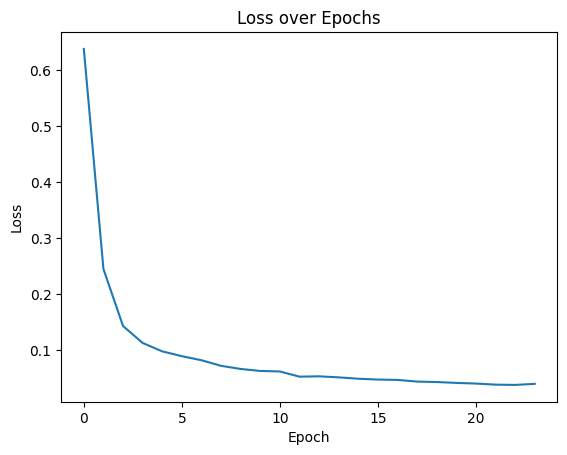

In [26]:
log = pd.read_csv('/content/drive/MyDrive/HW4/training.log')
print(f'Peak Validation Accuracy: {max(log.val_accuracy)}\nBest Epoch: {np.argmax(log.val_accuracy)+1}')
plt.plot(log.epoch, log.loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')

In [32]:
y_true = val_generator.classes
y_pred_keras = model.predict(val_generator)[:,1]

79/79 [==============================] - 66s 824ms/step


In [33]:
acc = ((y_pred_keras>0.5)==y_true).sum()/len(y_true)
print(f'Validation accuracy: {acc}')

Validation accuracy: 0.9401880376075215


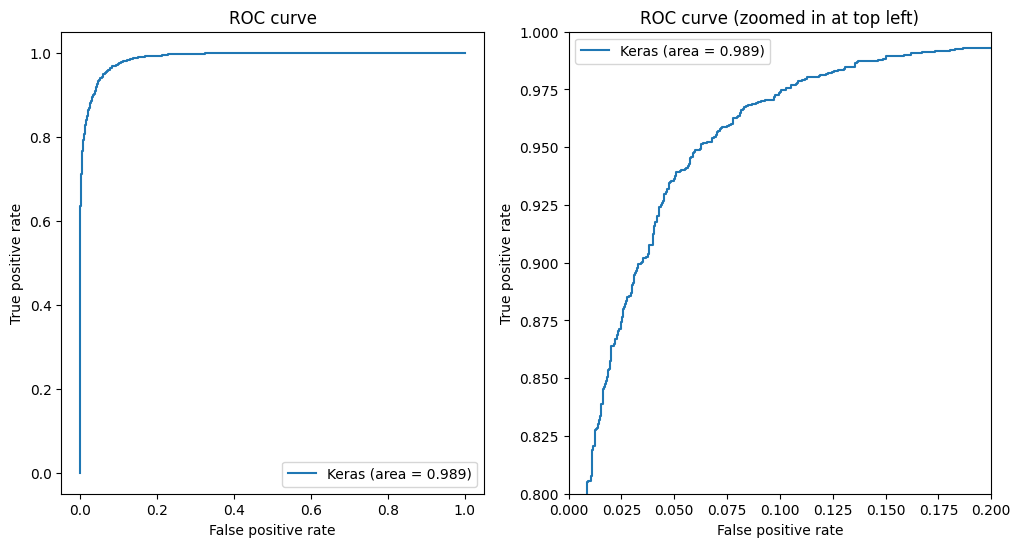

In [34]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred_keras)
auc_roc = auc(fpr_keras, tpr_keras)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the ROC curve
axs[0].plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_roc))
axs[0].set_xlabel('False positive rate')
axs[0].set_ylabel('True positive rate')
axs[0].set_title('ROC curve')
axs[0].legend(loc='best')

axs[1].set_xlim(0, 0.2)
axs[1].set_ylim(0.8, 1)
axs[1].plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_roc))
axs[1].set_xlabel('False positive rate')
axs[1].set_ylabel('True positive rate')
axs[1].set_title('ROC curve (zoomed in at top left)')
axs[1].legend(loc='best')

plt.show()


Text(0.5, 1.0, 'Precision-Recall Curve(zoomed in at top right)')

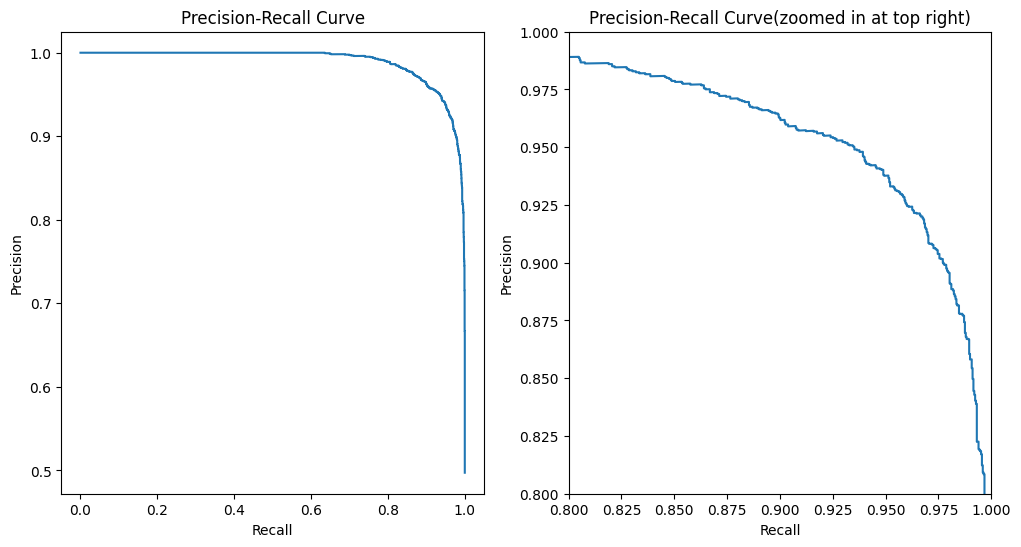

In [35]:
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_keras)
auc_prc = auc(recall, precision)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(recall, precision)
axs[0].set_xlabel('Recall')
axs[0].set_ylabel('Precision')
axs[0].set_title('Precision-Recall Curve')

axs[1].set_xlim(0.8,1)
axs[1].set_ylim(0.8,1)
axs[1].plot(recall, precision)
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve(zoomed in at top right)')


In [41]:
start = time.time()
wdir = 'HW04 - Data Challenge Photos/'
data = []
bad_imgs = os.path.join('bad_imgs/')
os.makedirs(bad_imgs, exist_ok=True)
for dirname, _, filenames in os.walk(wdir):
    for filename in filenames:
        dir = os.path.basename(dirname)  # Extract breed from the directory
        filetype = filename[-3:]
        try:
            image = ski.io.imread(f'{wdir}{dir}{filename}')
        except:
            try:
                print(f'Read error for "{wdir}{dir}/{filename}", attempting to move')
                os.rename(f'{wdir}{dir}{filename}', bad_imgs)
            except:
                os.remove(f'{wdir}{dir}{filename}')
                print(f'Could not move {wdir}{dir}/{filename}, removing file')
        else:
            if 'cat' in filename:
                dir = 'Cat'
            elif 'dog' in filename:
                dir = 'Dog'
            else:
                dir = 'Other'
            data.append({'filename': f'{wdir}{filename}', 'class': dir, 'filetype': filetype})
testdf = pd.DataFrame(data) #shuffling the data
cwd = os.getcwd()
end = time.time()
duration = end - start
print('Reading images took ', duration, ' seconds')

Reading images took  0.5758278369903564  seconds


In [43]:
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
dataframe=testdf,
directory=None,
x_col='filename',
y_col=None,
batch_size=32,
seed=42,
shuffle=False,
class_mode=None,
target_size=(200,224))

Found 25 validated image filenames.


In [44]:
predictions = model.predict(test_generator)

1/1 [==============================] - 1s 751ms/step


In [62]:
catdogdf = testdf[testdf['class']!='Other']

In [64]:
preds = predictions[testdf['class']!='Other']

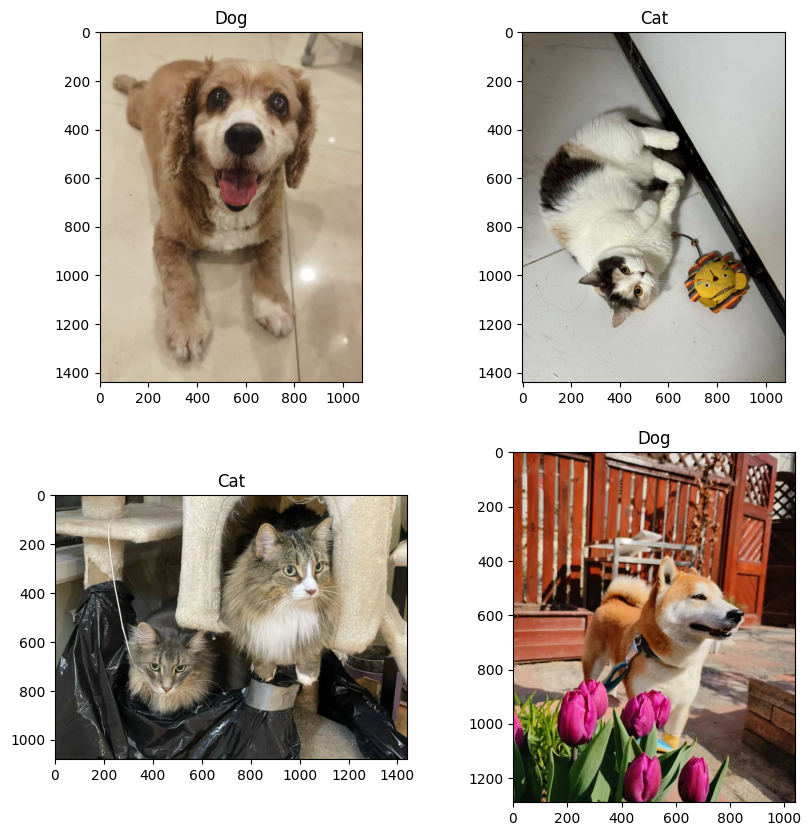

In [81]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs = axs.ravel()
for i in range(0,4):
    idx = random.choice(testdf.index)
    axs[i].imshow(Image.open(testdf['filename'][idx]))
    axs[i].set_title(testdf['class'][idx])

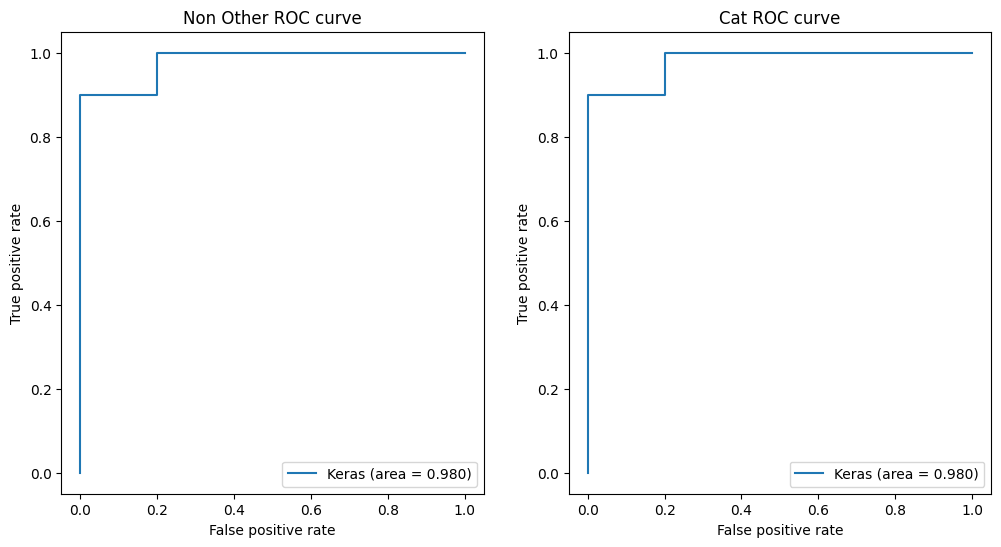

In [76]:
fpr_20, tpr_20, thresholds_20 = roc_curve(catdogdf['class']=='Cat', preds[:,0])
auc_20 = auc(fpr_20, tpr_20)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the ROC curve
axs[0].plot(fpr_20, tpr_20, label='Keras (area = {:.3f})'.format(auc_20))
axs[0].set_xlabel('False positive rate')
axs[0].set_ylabel('True positive rate')
axs[0].set_title('Non Other ROC curve')
axs[0].legend(loc='best')

fpr_25, tpr_25, thresholds_25 = roc_curve(testdf['class']=='Cat', predictions[:,0])
auc_25 = auc(fpr_25, tpr_25)
axs[1].plot(fpr_25, tpr_25, label='Keras (area = {:.3f})'.format(auc_25))
axs[1].set_xlabel('False positive rate')
axs[1].set_ylabel('True positive rate')
axs[1].set_title('Cat ROC curve')
axs[1].legend(loc='best')


plt.show()


In [80]:
acc = ((preds[:,0]>0.5)==(catdogdf['class']=='Cat')).sum()/len(preds)
print(f'Validation accuracy: {acc}')

Validation accuracy: 0.9


In [84]:
cat = (predictions[:,0]>0.5)

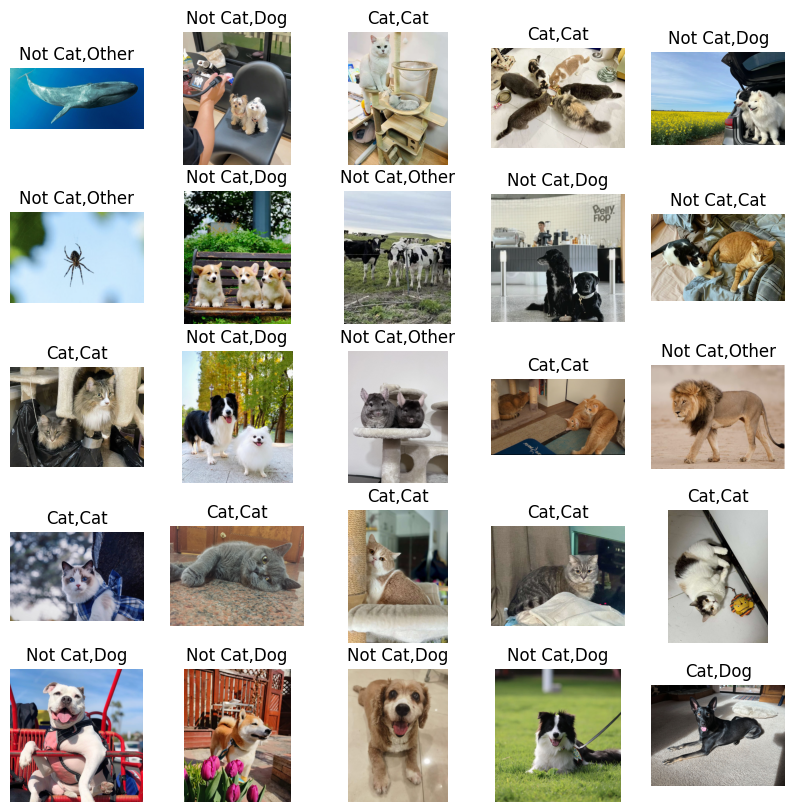

In [98]:
fig, ax = plt.subplots(5,5, figsize = (10,10))
for i in range(25):
    ax[i//5][i%5].imshow(Image.open(testdf['filename'][i]))
    ax[i//5][i%5].axis('off')
    name = 'Cat' if cat[i] else 'Not Cat'
    klass = testdf['class'][i]
    ax[i//5][i%5].set_title(f'{name},{klass}')